In [22]:
# loading installed r package
library(dplyr)
library(tidyverse)
library(readr)
library(psych)
#library(skimr)
#library(tableone)
library(survival) 
library(ggplot2) 
#library(survminer)


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




In [14]:
# 2: read data
lc = "../SMC/smc_bmi_breast_cancer.csv"
data = read.csv(lc, header = TRUE)
head(data)

,number,opdate,age,age_g,bmi,tn,stage,distmeta,dmdate,expire,lastfu_date
,<int>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<chr>
1,1,2008-01-03,69,4,26.90467,0,2,0,2012-03-13,0,2012-03-13
2,2,2011-11-22,43,2,17.91241,0,2,0,2012-11-06,0,2016-02-04
3,3,2011-04-15,44,2,21.95249,0,2,0,2012-08-13,0,2015-10-07
4,4,2011-10-26,80,4,28.00000,1,2,0,2012-11-13,0,2015-12-29
5,5,2011-07-13,57,3,23.69383,0,2,0,2012-09-24,0,2015-10-21
6,6,2011-10-25,74,4,15.95684,1,1,0,2012-11-08,0,2016-01-06


In [26]:
# modify the data set 
data$number <- as.character(data$number)
summary(data)

    number              opdate                age        age_g   
 Length:4721        Min.   :2007-01-03   Min.   :21.00   1: 732  
 Class :character   1st Qu.:2008-08-19   1st Qu.:42.00   2:1969  
 Mode  :character   Median :2009-10-13   Median :48.00   3:1326  
                    Mean   :2009-09-27   Mean   :48.95   4: 694  
                    3rd Qu.:2010-11-25   3rd Qu.:54.00           
                    Max.   :2011-12-29   Max.   :88.00           
      bmi              tn             stage          distmeta      
 Min.   :10.69   Min.   :0.0000   Min.   :1.000   Min.   :0.00000  
 1st Qu.:21.21   1st Qu.:0.0000   1st Qu.:1.000   1st Qu.:0.00000  
 Median :23.07   Median :0.0000   Median :2.000   Median :0.00000  
 Mean   :23.46   Mean   :0.1493   Mean   :1.668   Mean   :0.04639  
 3rd Qu.:25.37   3rd Qu.:0.0000   3rd Qu.:2.000   3rd Qu.:0.00000  
 Max.   :45.55   Max.   :1.0000   Max.   :3.000   Max.   :1.00000  
    dmdate              expire         lastfu_date         fol

In [28]:
# 3: generate new variables

# exposure 
data$age_g <-as.factor(data$age_g)
table(data$age_g)

# outcome 
data$follow_year <- (data$lastfu_date - data$opdate)/365.25 
summary(data$follow_year)

table(data$expire)


   1    2    3    4 
 732 1969 1326  694 

  Length    Class     Mode 
    4721 difftime  numeric 


   0    1 
4603  118 

In [29]:
# 날짜 형식으로 변환
data$lastfu_date <- as.Date(data$lastfu_date, format = "%Y-%m-%d")
data$opdate <- as.Date(data$opdate, format = "%Y-%m-%d")

# follow_year 계산
data$follow_year <- (data$lastfu_date - data$opdate) / 365.25
summary(data$follow_year)

  Length    Class     Mode 
    4721 difftime  numeric 

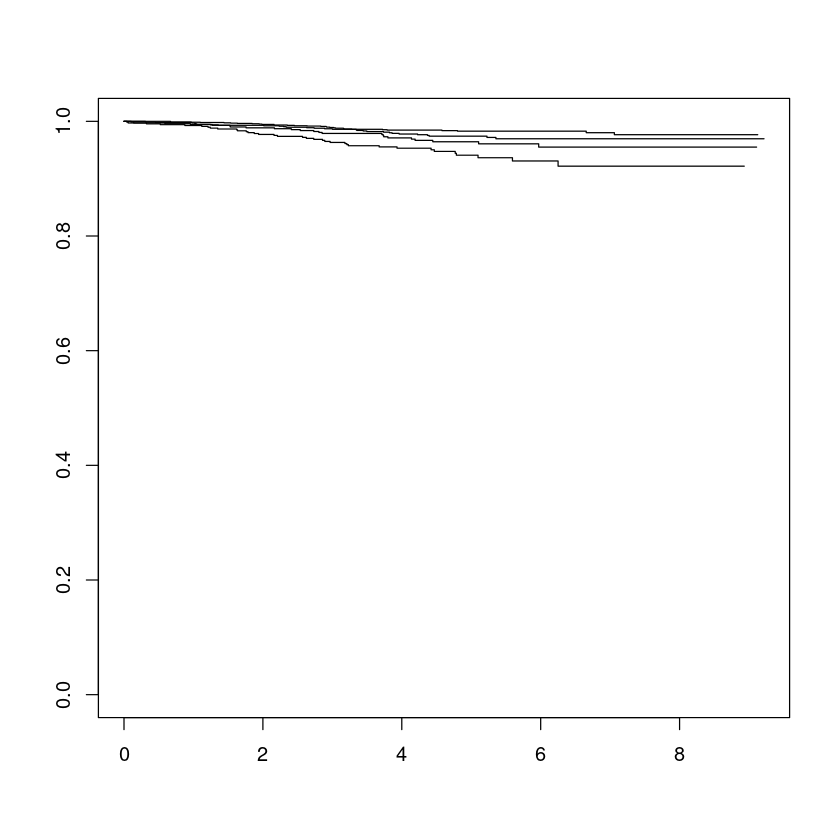

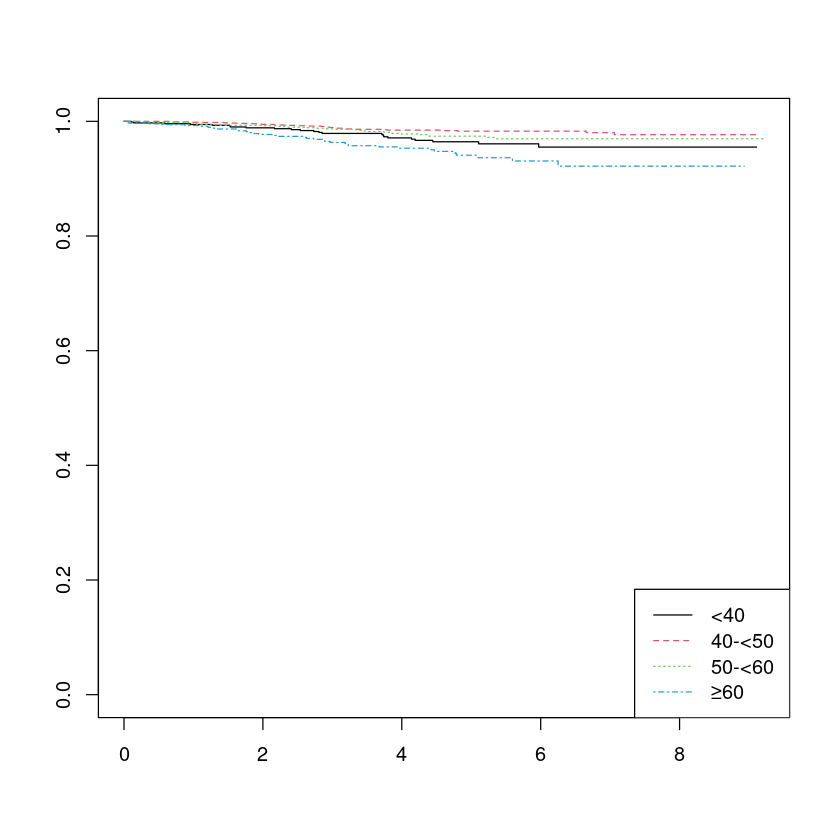

In [31]:
# 4: Kaplan-Meier Curve and log-rank test

# Kaplan-Meier Curve
#survfit
survival_km <- survfit(Surv(follow_year,expire==1) ~ age_g, data=data)
plot(survival_km)
plot(survival_km, col=1:4, lty=1:4)
legend("bottomright", legend=c("<40", "40-<50", "50-<60", "≥60"), col=1:4, lty=1:4)

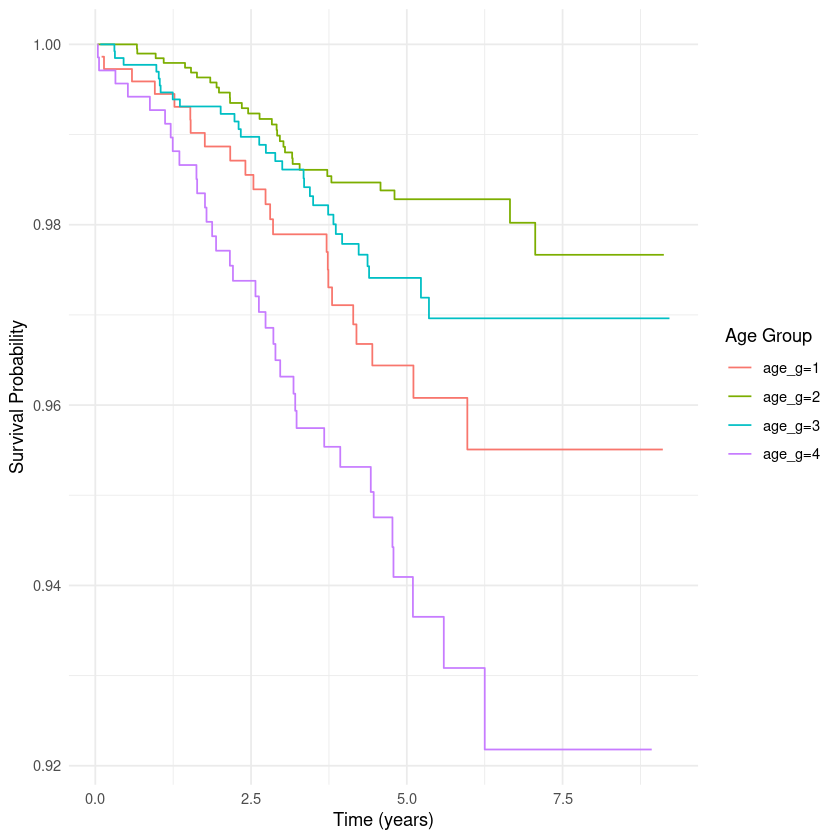

In [32]:
# Create survival analysis results
survival_km <- survfit(Surv(follow_year, expire == 1) ~ age_g, data = data)

# Convert survival results into a data frame for ggplot
library(broom)
survival_df <- tidy(survival_km)

# Basic Kaplan-Meier curve visualization using ggplot2
library(ggplot2)
ggplot(survival_df, aes(x = time, y = estimate, color = strata)) +
  geom_step() +  # Step function for Kaplan-Meier curve
  labs(x = "Time (years)", y = "Survival Probability", color = "Age Group") +
  theme_minimal()  # Minimal theme for a clean plot

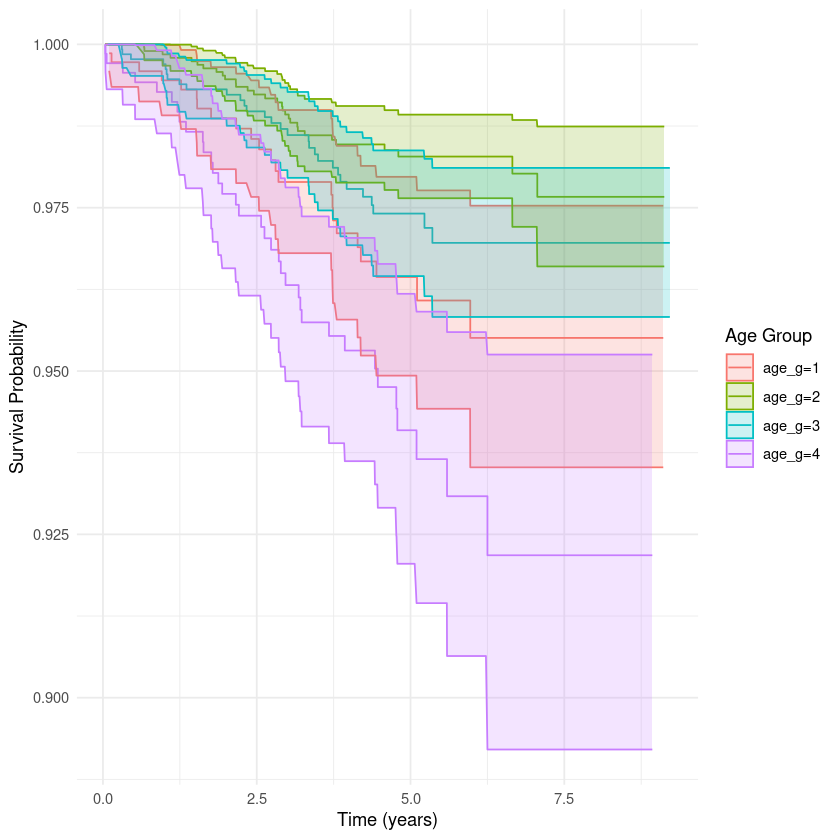

In [33]:
# Kaplan-Meier curve with confidence intervals (CI)
ggplot(survival_df, aes(x = time, y = estimate, color = strata)) +
  geom_step() +  # Kaplan-Meier step curve
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = strata), alpha = 0.2) +  # Confidence interval shading
  labs(x = "Time (years)", y = "Survival Probability", color = "Age Group", fill = "Age Group") +
  theme_minimal()

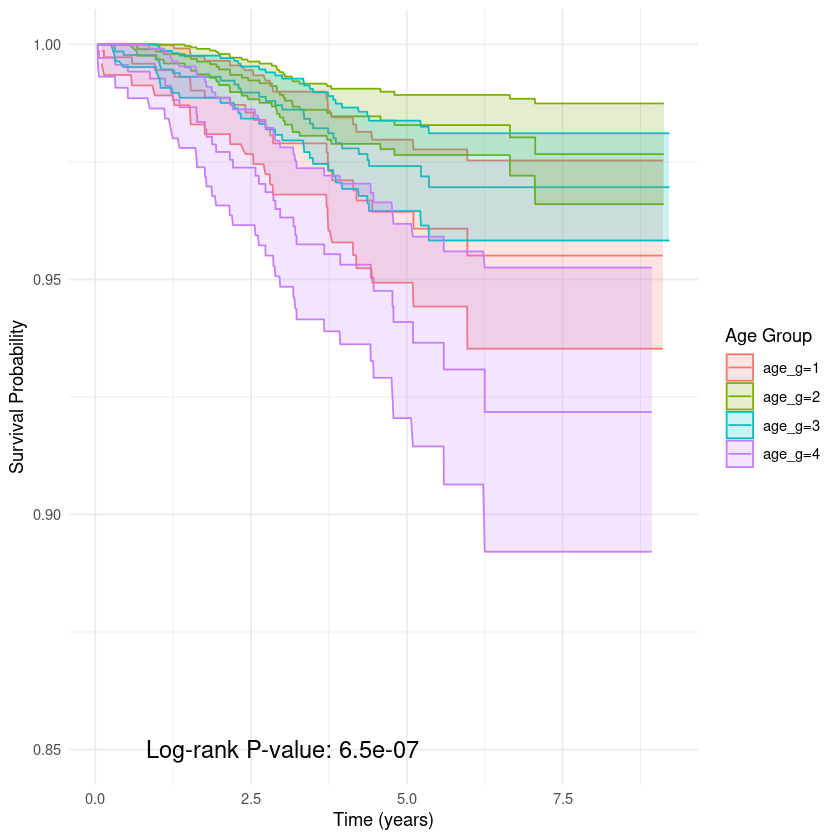

In [40]:
# Perform log-rank test
logrank_test <- survdiff(Surv(follow_year, expire == 1) ~ age_g, data = data)

# Calculate P-value from the log-rank test
p_value <- 1 - pchisq(logrank_test$chisq, length(logrank_test$n) - 1)
p_value_text <- paste("Log-rank P-value:", format(p_value, digits = 3))

# Kaplan-Meier curve with P-value annotation
ggplot(survival_df, aes(x = time, y = estimate, color = strata)) +
  geom_step() +  # Kaplan-Meier step curve
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high, fill = strata), alpha = 0.2) +  # Confidence interval shading
  labs(x = "Time (years)", y = "Survival Probability", color = "Age Group", fill = "Age Group") +  # Labels
  annotate("text", x = 3, y = 0.85, label = p_value_text, size = 5, color = "black") +  # P-value annotation
  theme_minimal()  # Minimal theme


In [38]:
# Generate risk table (number at risk)
risk_table <- summary(survival_km)$table

# Plot risk table using ggplot
ggplot(as.data.frame(risk_table), aes(x = time, y = n.risk, color = strata)) +
  geom_line() +  # Line plot for number at risk over time
  labs(x = "Time (years)", y = "Number at Risk", color = "Age Group") +  # Add labels and color legend
  theme_minimal()  # Minimal theme for clean visuals


ERROR while rich displaying an object: Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'n.risk' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = err

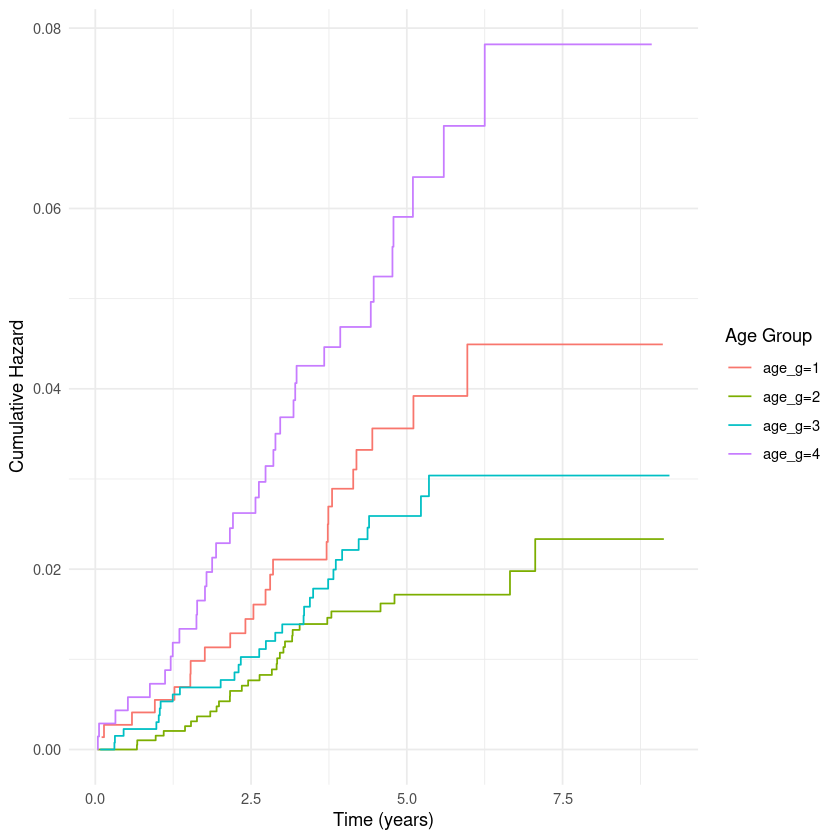

In [36]:
# Plot cumulative hazard (1 - Kaplan-Meier curve)
ggplot(survival_df, aes(x = time, y = 1 - estimate, color = strata)) +
  geom_step() +  # Step curve for cumulative hazard
  labs(x = "Time (years)", y = "Cumulative Hazard", color = "Age Group") +
  theme_minimal()

In [41]:
# log-rank test
#survdiff
survdiff(Surv(follow_year,expire)~age_g,data=data)
survdiff(Surv((data$lastfu_date - data$opdate)/365.25,expire)~age_g,data=data)

Call:
survdiff(formula = Surv(follow_year, expire) ~ age_g, data = data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
age_g=1  732       23     18.0     1.364     1.610
age_g=2 1969       30     50.5     8.302    14.524
age_g=3 1326       30     33.2     0.311     0.433
age_g=4  694       35     16.3    21.537    25.005

 Chisq= 31.6  on 3 degrees of freedom, p= 7e-07 

Call:
survdiff(formula = Surv((data$lastfu_date - data$opdate)/365.25, 
    expire) ~ age_g, data = data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
age_g=1  732       23     18.0     1.364     1.610
age_g=2 1969       30     50.5     8.302    14.524
age_g=3 1326       30     33.2     0.311     0.433
age_g=4  694       35     16.3    21.537    25.005

 Chisq= 31.6  on 3 degrees of freedom, p= 7e-07 

In [42]:
# 5: incidence rate  
#---- incidence rate 
#tapply
total <-cbind(tapply(data$expire,data$age_g,sum),tapply(data$follow_year,data$age_g,sum))
#Add up the number of events within the stratifying variable
#Add up the amount of follow-up time within the stratifying the variable
rates <- tapply(data$expire,data$age_g,sum)/tapply(data$follow_year,data$age_g,sum)*10^3
#Given rates per 1,000 person years
ratetable <- (cbind(total,rates))
ratetable

,,,rates
1,23,3353.465,6.858578
2,30,9451.529,3.174090
3,30,6129.659,4.894236
4,35,2982.516,11.735058


In [43]:
# 6: cox proportional hazards model 
#---- univariable
#-- continuous exposure
#coxph
model1 <-(coxph(Surv(follow_year,expire==1) ~ age, data=data))
summary(model1)

#-categorical exposure
model2 <-(coxph(Surv(follow_year,expire==1) ~ age_g, data=data))
summary(model2)

Call:
coxph(formula = Surv(follow_year, expire == 1) ~ age, data = data)

  n= 4721, number of events= 118 

        coef exp(coef) se(coef)     z Pr(>|z|)    
age 0.036228  1.036892 0.008847 4.095 4.23e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
age     1.037     0.9644     1.019     1.055

Concordance= 0.58  (se = 0.031 )
Likelihood ratio test= 15.93  on 1 df,   p=7e-05
Wald test            = 16.77  on 1 df,   p=4e-05
Score (logrank) test = 16.84  on 1 df,   p=4e-05


Call:
coxph(formula = Surv(follow_year, expire == 1) ~ age_g, data = data)

  n= 4721, number of events= 118 

          coef exp(coef) se(coef)      z Pr(>|z|)   
age_g2 -0.7639    0.4658   0.2772 -2.756  0.00585 **
age_g3 -0.3444    0.7086   0.2772 -1.243  0.21399   
age_g4  0.5240    1.6887   0.2685  1.951  0.05100 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

       exp(coef) exp(-coef) lower .95 upper .95
age_g2    0.4658     2.1467    0.2706     0.802
age_g3    0.7086     1.4112    0.4116     1.220
age_g4    1.6887     0.5922    0.9977     2.858

Concordance= 0.626  (se = 0.026 )
Likelihood ratio test= 27.49  on 3 df,   p=5e-06
Wald test            = 28.74  on 3 df,   p=3e-06
Score (logrank) test = 31.55  on 3 df,   p=6e-07


In [44]:
# reference change
model3 <-(coxph(Surv(follow_year,expire==1) ~ C(age_g,base=2), data=data))
summary(model3)


#---- multivariable
#-- continuous exposure
data$stage <-as.factor(data$stage)

model4 <-(coxph(Surv(follow_year,expire==1) ~ age+stage+bmi, data=data))
summary(model4)

#-categorical exposure
model5 <-(coxph(Surv(follow_year,expire==1) ~ C(age_g,base=2)+stage+bmi, data=data))
summary(model5)

# -------------------------------------------------------------------------
# 7: proportional hazard assumption test  
#cox.zph
cox.zph(model5)

Call:
coxph(formula = Surv(follow_year, expire == 1) ~ C(age_g, base = 2), 
    data = data)

  n= 4721, number of events= 118 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
C(age_g, base = 2)1 0.7639    2.1467   0.2772 2.756  0.00585 ** 
C(age_g, base = 2)3 0.4195    1.5213   0.2583 1.624  0.10428    
C(age_g, base = 2)4 1.2879    3.6253   0.2490 5.172 2.32e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
C(age_g, base = 2)1     2.147     0.4658     1.247     3.696
C(age_g, base = 2)3     1.521     0.6574     0.917     2.524
C(age_g, base = 2)4     3.625     0.2758     2.225     5.906

Concordance= 0.626  (se = 0.026 )
Likelihood ratio test= 27.49  on 3 df,   p=5e-06
Wald test            = 28.74  on 3 df,   p=3e-06
Score (logrank) test = 31.55  on 3 df,   p=6e-07


Call:
coxph(formula = Surv(follow_year, expire == 1) ~ age + stage + 
    bmi, data = data)

  n= 4721, number of events= 118 

           coef exp(coef) se(coef)     z Pr(>|z|)    
age    0.035716  1.036362 0.009248 3.862 0.000112 ***
stage2 1.289826  3.632155 0.277793 4.643 3.43e-06 ***
stage3 2.249328  9.481361 0.285168 7.888 3.08e-15 ***
bmi    0.010642  1.010699 0.029502 0.361 0.718310    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

       exp(coef) exp(-coef) lower .95 upper .95
age        1.036     0.9649    1.0177     1.055
stage2     3.632     0.2753    2.1072     6.261
stage3     9.481     0.1055    5.4217    16.581
bmi        1.011     0.9894    0.9539     1.071

Concordance= 0.743  (se = 0.024 )
Likelihood ratio test= 90.68  on 4 df,   p=<2e-16
Wald test            = 83.38  on 4 df,   p=<2e-16
Score (logrank) test = 103.3  on 4 df,   p=<2e-16


Call:
coxph(formula = Surv(follow_year, expire == 1) ~ C(age_g, base = 2) + 
    stage + bmi, data = data)

  n= 4721, number of events= 118 

                       coef exp(coef) se(coef)     z Pr(>|z|)    
C(age_g, base = 2)1 0.72014   2.05472  0.27910 2.580  0.00987 ** 
C(age_g, base = 2)3 0.38646   1.47175  0.25945 1.490  0.13634    
C(age_g, base = 2)4 1.24231   3.46361  0.25709 4.832 1.35e-06 ***
stage2              1.25878   3.52111  0.27795 4.529 5.93e-06 ***
stage3              2.22818   9.28296  0.28523 7.812 5.63e-15 ***
bmi                 0.01951   1.01970  0.02847 0.685  0.49317    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
C(age_g, base = 2)1     2.055     0.4867    1.1890     3.551
C(age_g, base = 2)3     1.472     0.6795    0.8851     2.447
C(age_g, base = 2)4     3.464     0.2887    2.0926     5.733
stage2                  3.521     0.2840    2.0421     6.071
stage3                

Warning message:
“contrasts dropped from factor C(age_g, base = 2)”


                    chisq df    p
C(age_g, base = 2) 0.0283  3 1.00
stage              1.3963  2 0.50
bmi                1.3932  1 0.24
GLOBAL             3.3627  6 0.76